In [59]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5):

    '''
    From Joel's answer at https://stackoverflow.com/a/29597209/2966723.  
    Licensed under Creative Commons Attribution-Share Alike 
    
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    G: the graph (must be a tree)
    
    root: the root node of current branch 
    - if the tree is directed and this is not given, 
      the root will be found and used
    - if the tree is directed and this is given, then 
      the positions will be just for the descendants of this node.
    - if the tree is undirected and not given, 
      then a random choice will be used.
    
    width: horizontal space allocated for this branch - avoids overlap with other branches
    
    vert_gap: gap between levels of hierarchy
    
    vert_loc: vertical location of root
    
    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, width=1., vert_gap = 0.2, vert_loc = 0, xcenter = 0.5, pos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''
    
        if pos is None:
            pos = {root:(xcenter,vert_loc)}
        else:
            pos[root] = (xcenter, vert_loc)
        children = list(G.neighbors(root))
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            dx = width/len(children) 
            nextx = xcenter - width/2 - dx/2
            for child in children:
                nextx += dx
                pos = _hierarchy_pos(G,child, width = dx, vert_gap = vert_gap, 
                                    vert_loc = vert_loc-vert_gap, xcenter=nextx,
                                    pos=pos, parent = root)
        return pos

            
    return _hierarchy_pos(G, root, width, vert_gap, vert_loc, xcenter)

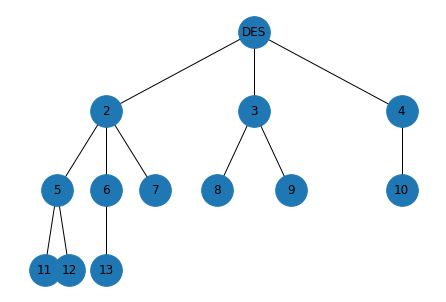

In [65]:
import matplotlib.pyplot as plt
import networkx as nx
G=nx.Graph()
G.add_edges_from([('DES',2), ('DES',3), ('DES',4), (2,5), (2,6), (2,7), (3,8), (3,9), (4,10),
                  (5,11), (5,12), (6,13)])
pos = hierarchy_pos(G,'DES')    
nx.draw(G, pos=pos, with_labels=True, node_size=1000)

In [1]:
import numpy as np

In [561]:
class Node:
    def __init__(self, node_type, value=None):
        
        self.type = node_type
        self.children = []
        self.level = 1
        
        if isinstance(value, list):
            self.probs = value
            self.value = 0
        else:
            self.value = value
        
        
    def describe(self):
        print(' '*4*self.level, self.level, 'DESCRIBE:',self.type, '->',self.value)
        for c in self.children:
            c.level = self.level + 1 
            c.describe()
        
        #self.level = 1
    
    
    def compute(self):
        val = 0
        
        if self.type == "T":
            print(' '*4*self.level + 'TYPE T')
            val = self.value
            print(' '*4*self.level + 'val', val)
            
        elif self.type == "C":
            print(' '*4*self.level + 'TYPE C')
            
            c_values = []
            for c in self.children:
                c.level += 1
                c_values.append(c.compute())
                
            for p,v in zip(self.probs, c_values):
                val += p*v
            print(' '*4*self.level + 'val:',val)
                    
        elif self.type == "D":
            print('TYPE D')
            val = [c.compute for c in self.children]
        
        #self.level = 1
            
        self.value = val
        
        return val
    

In [584]:
class EasyNode():
    def __init__(self, probs, values):
        self.probs = probs
        self.values = values
            
    def compute(self):
        val = 0

        for p,v in zip(self.probs, self.values):
            val += p*v
            
        self.value = val
        
        return val
        

In [585]:
t_nodes_1 = [
['T', 110],
['T', -15],
]

In [586]:
c_nodes = [
    ['C', [.05, .95]],
]

In [587]:
for i in t_nodes:
    n = Node(*i)
    n.describe()
    n.compute()
    print('')

     1 DESCRIBE: T -> 110
    TYPE T
    val 110

     1 DESCRIBE: T -> -15
    TYPE T
    val -15



In [588]:
c = Node(*['C', [.05, .95]])
for i in t_nodes:
    n = Node(*i)
    c.children.append(n)
    
c.describe()

     1 DESCRIBE: C -> 0
         2 DESCRIBE: T -> 110
         2 DESCRIBE: T -> -15


In [589]:
c.compute()

    TYPE C
            TYPE T
            val 110
            TYPE T
            val -15
    val: -8.75


-8.75

In [567]:
t_nodes_2 = [
['T', 110],
['T', -15],
]

In [568]:
c_nodes = [
    ['C', [.05, .95]],
    ['C', [.15, .85]]
]

In [569]:
d = Node(*['C',[.45,.55]])
for node in c_nodes:
    n = Node(*node)
    d.children.append(n)

In [570]:
#d.describe()

In [571]:
for n in t_nodes_1:
    d.children[0].children.append(Node(*n))

In [572]:
for n in t_nodes_1:
    d.children[1].children.append(Node(*n))

In [573]:
d.describe()

     1 DESCRIBE: C -> 0
         2 DESCRIBE: C -> 0
             3 DESCRIBE: T -> 110
             3 DESCRIBE: T -> -15
         2 DESCRIBE: C -> 0
             3 DESCRIBE: T -> 110
             3 DESCRIBE: T -> -15


In [574]:
d.compute()

    TYPE C
            TYPE C
                TYPE T
                val 110
                TYPE T
                val -15
            val: -8.75
            TYPE C
                TYPE T
                val 110
                TYPE T
                val -15
            val: 3.75
    val: -1.875


-1.875

In [591]:
r = Node('C')
a.probs = [.05, .95 ]
a.values = [110,-15]
a.compute()

-8.75

In [598]:
r = EasyNode(*[[.05, .95 ],[110, -15 ]])
print(r.compute())
r = EasyNode(*[[.15, .85 ],[110, -15 ]])
print(r.compute())
r = EasyNode(*[[.15, .85 ],[75, -15 ]])
print(r.compute())
r = EasyNode(*[[.3, .7 ],[75, -15 ]])
print(r.compute())
r = EasyNode(*[[.35, .65 ],[25, -15 ]])
print(r.compute())
r = EasyNode(*[[.5, .5 ],[25, -15 ]])
print(r.compute())

-8.75
3.75
-1.5
12.0
-1.0
5.0


In [49]:
a = Node()
a.probs = [.15, .85 ]
a.values = [110,-15]
a.compute()

3.75

In [50]:
a = Node()
a.probs = [.15, .85 ]
a.values = [75,-15]
a.compute()

-1.5

In [51]:
a = Node()
a.probs = [.3, .7 ]
a.values = [75,-15]
a.compute()

12.0

In [52]:
a = Node()
a.probs = [.35, .65 ]
a.values = [25,-15]
a.compute()

-1.0

In [53]:
a = Node()
a.probs = [.5, .5 ]
a.values = [25,-15]
a.compute()

5.0

SECOND

In [55]:
a = Node()
a.probs = [.45, .55 ]
a.values = [-13.15,3.75]
a.compute()

-3.8550000000000004

In [56]:
a = Node()
a.probs = [.45, .55 ]
a.values = [-1.5,12]
a.compute()

5.925000000000001

In [57]:
a = Node()
a.probs = [.45, .55 ]
a.values = [-1, 5]
a.compute()

2.3